# Studying How to Efficiently and Effectively Guide Models with Explanations
### Reproducibility Study
FACT AI 2024 UvA - Group 24

## Imports

In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pandas as pd
import quant_plotting_utils as quant
import qual_plotting_utils as qual
import seaborn as sns
import survey_plotting_utils as survey
import numpy as np
from scipy import stats
from train import main
from scipy.stats import binomtest
from statsmodels.stats.contingency_tables import mcnemar

/scratch-local/scur1036/ipykernel_3308186/3927257704.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Training the different model configurations

### Reproducibility Experiments
The following two cells set up the arguments that are passed to the main script after which training and evaluation can be ran for different configurations (in this case on a small subset of the train, val and test data for demonstration purposes).

In [2]:
@dataclass
class Parser:
    model_backbone: str = 'bcos'
    model_path: str = "checkpoints/COCO2014/bcos_standard_attrBCos_loclossL1_origNone_resnet50_lr0.0001_sll0.0_layerFinal/model_checkpoint_f1_best.pt"
    data_path: str = "datasets/"
    total_epochs: int = 1
    learning_rate: float = 1e-4
    log_path: str = "logs/"
    save_path: str = "checkpoints/"
    seed: int = 0
    train_batch_size: int = 16
    dataset: str = 'COCO2014'
    localization_loss_lambda: float = 1e-3
    layer: str = "Input"
    localization_loss_fn: str = "Energy"
    attribution_method: str = "BCos"
    optimize_explanations: bool = True
    min_fscore: float = -1
    pareto: bool = True
    annotated_fraction: float = 1.0
    evaluation_frequency: int = 1
    eval_batch_size: int = 4
    box_dilation_percentage: float = 0

In [3]:
args = Parser()
main(args)

## Quantitative Results

### Data Parsing
The evaluation on the test set produces json files that store the metrics such as EPG, IoU or F1 score. The filenames allow for parsing of the data based on the experiment and the model configuration.

In [4]:
baseline_data, lossfn_data, dilation_data, sparse_data = quant.load_jsons(root="result_jsons/")

### Figure 5 Reproduction - MS COCO results for EPG vs F1

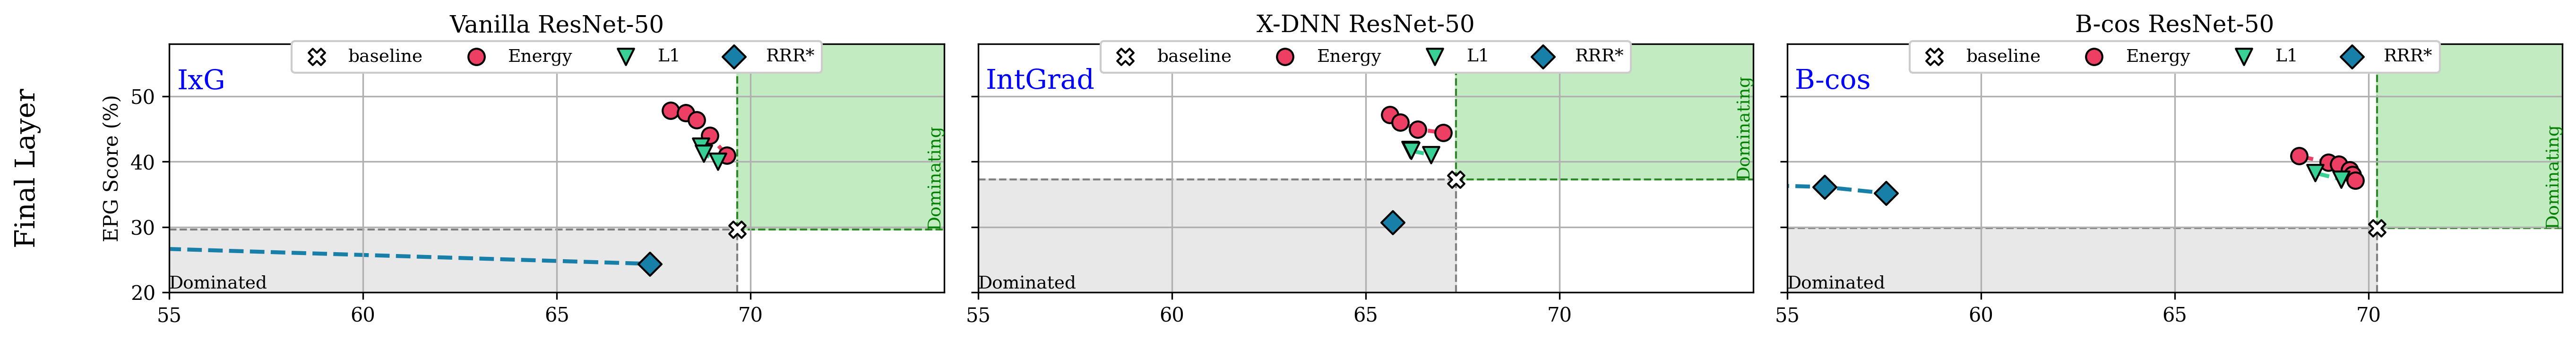

In [5]:
quant.pareto_plot(lossfn_data, baseline_data, score_type='BB-Loc', filter_front=True, show_layer="Final")

### Figure 6 Reproduction - MS COCO results for IoU vs F1

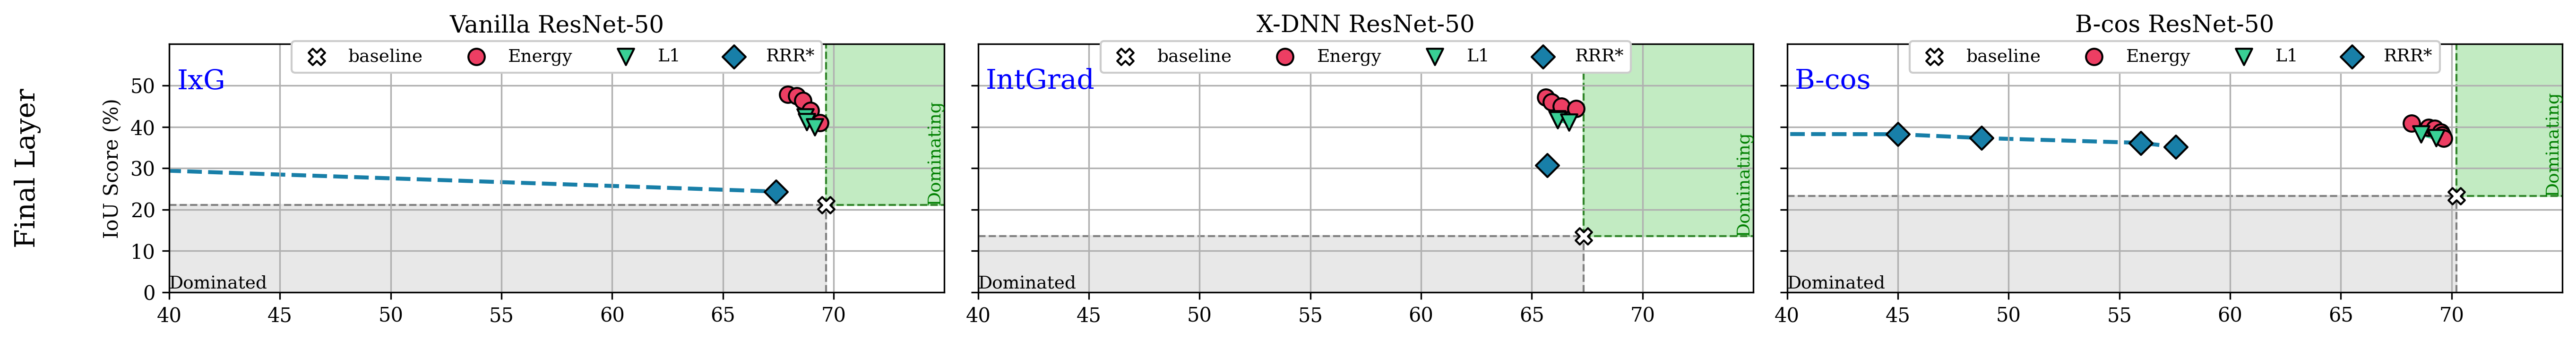

In [6]:
quant.pareto_plot(lossfn_data, baseline_data, score_type='BB-IoU', filter_front=True, show_layer="Final")

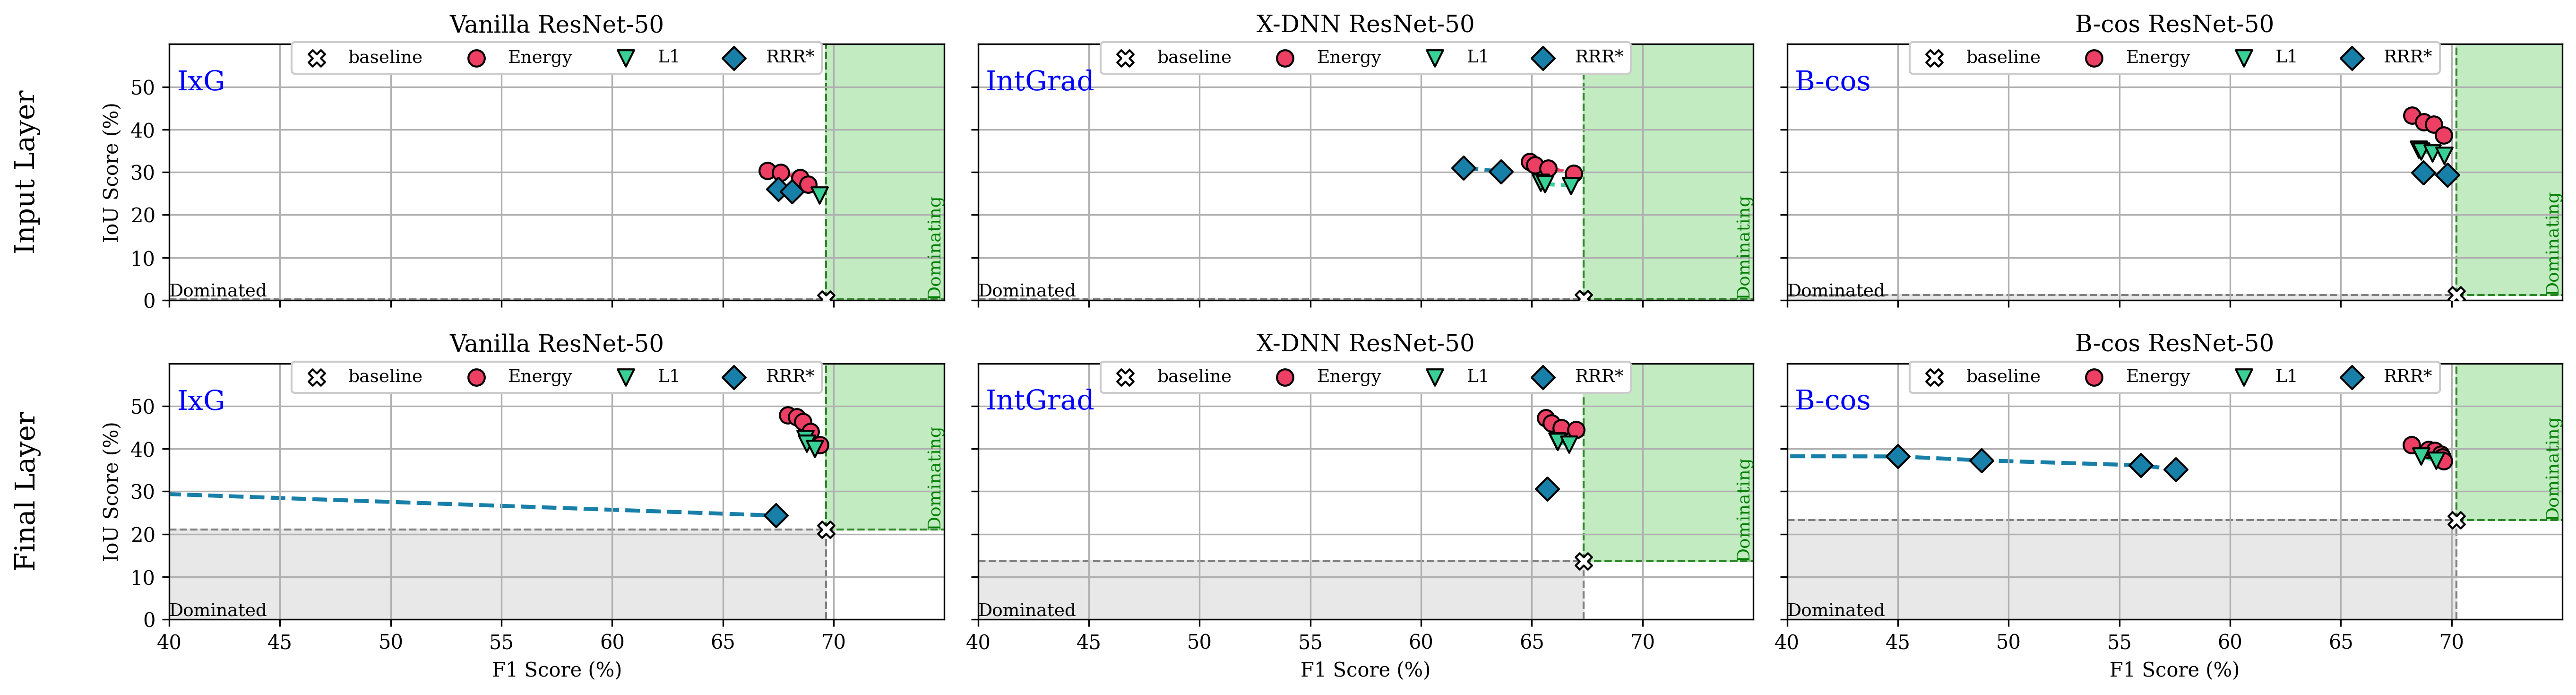

In [7]:
quant.pareto_plot(lossfn_data, baseline_data, score_type='BB-IoU', filter_front=True)

### Figure 10 Reproduction - Quantitative Results for Dilated Bounding Boxes

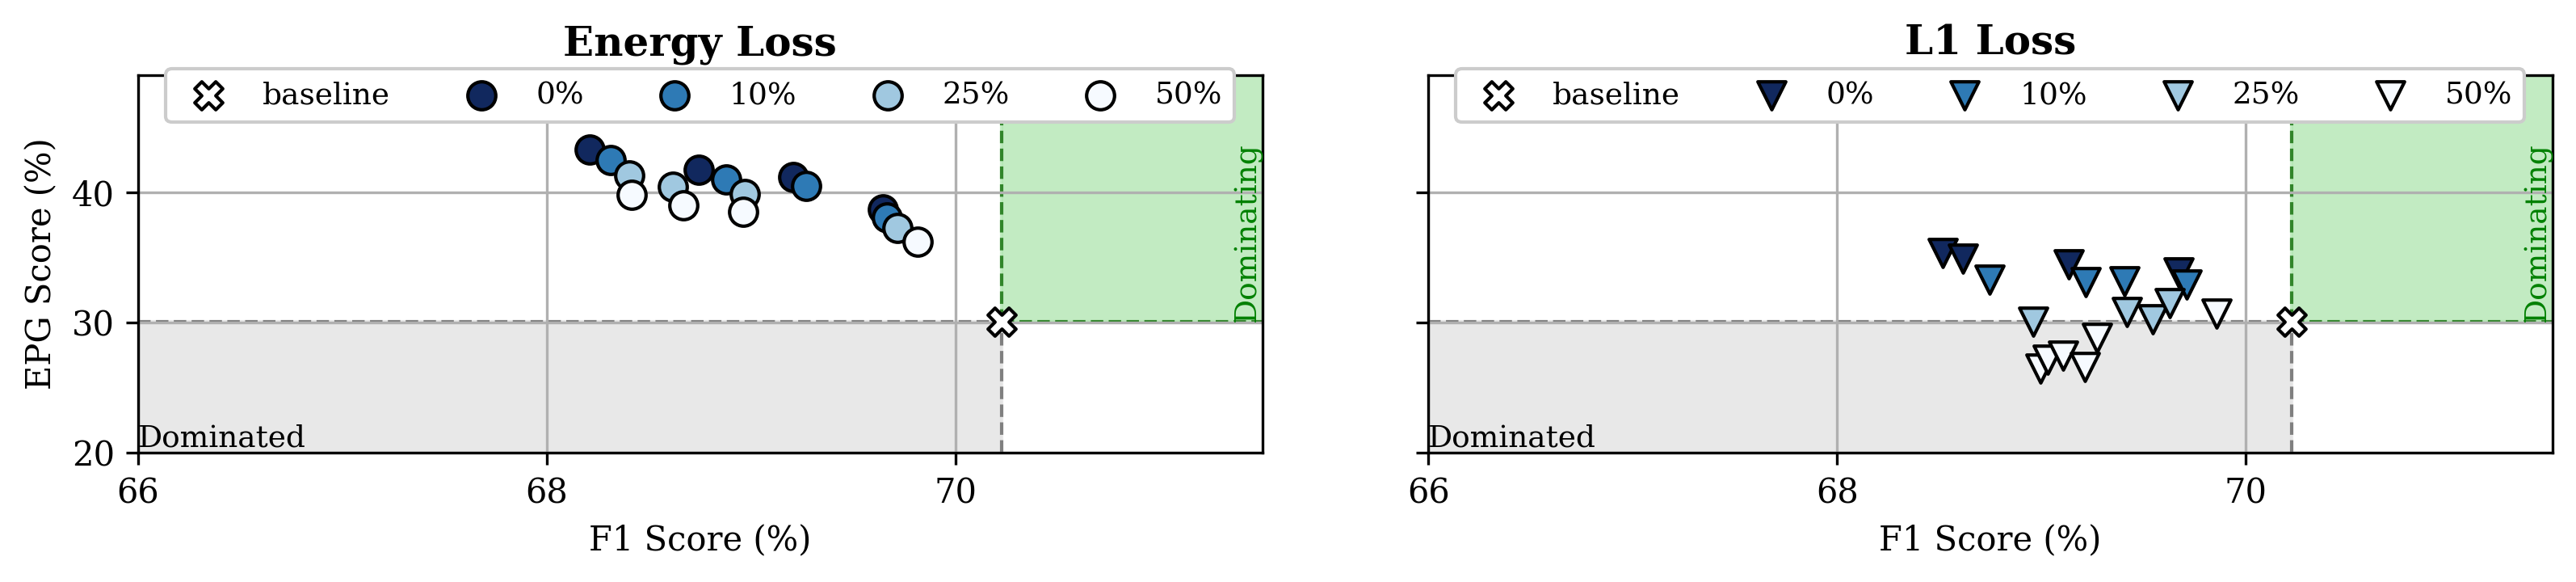

In [8]:
quant.plot_dilations(dilation_data, baseline_data, metric="EPG")

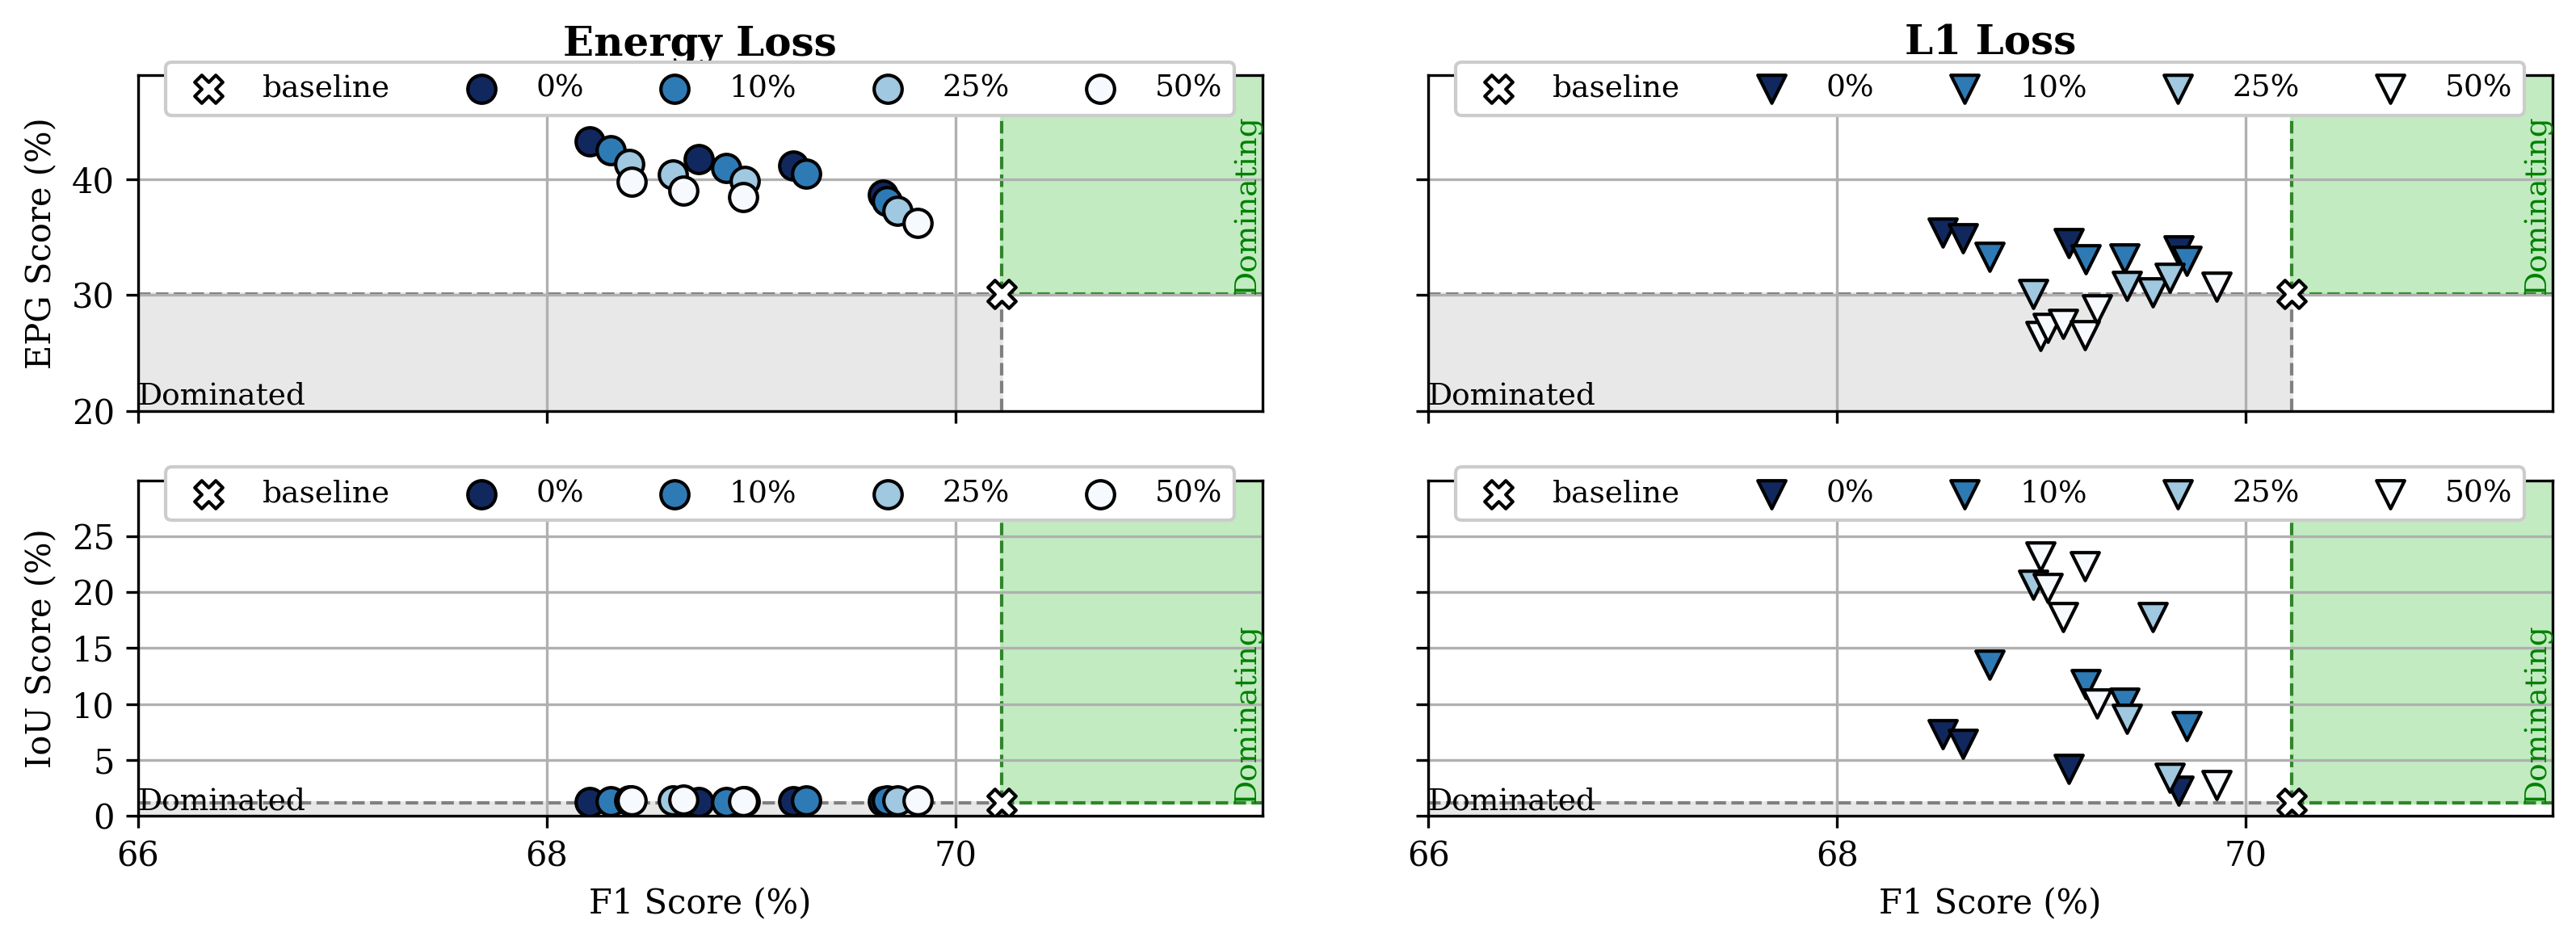

In [9]:
quant.plot_dilations(dilation_data, baseline_data)

### Figure 12 Reproduction - EPG Results with Limited Annotations

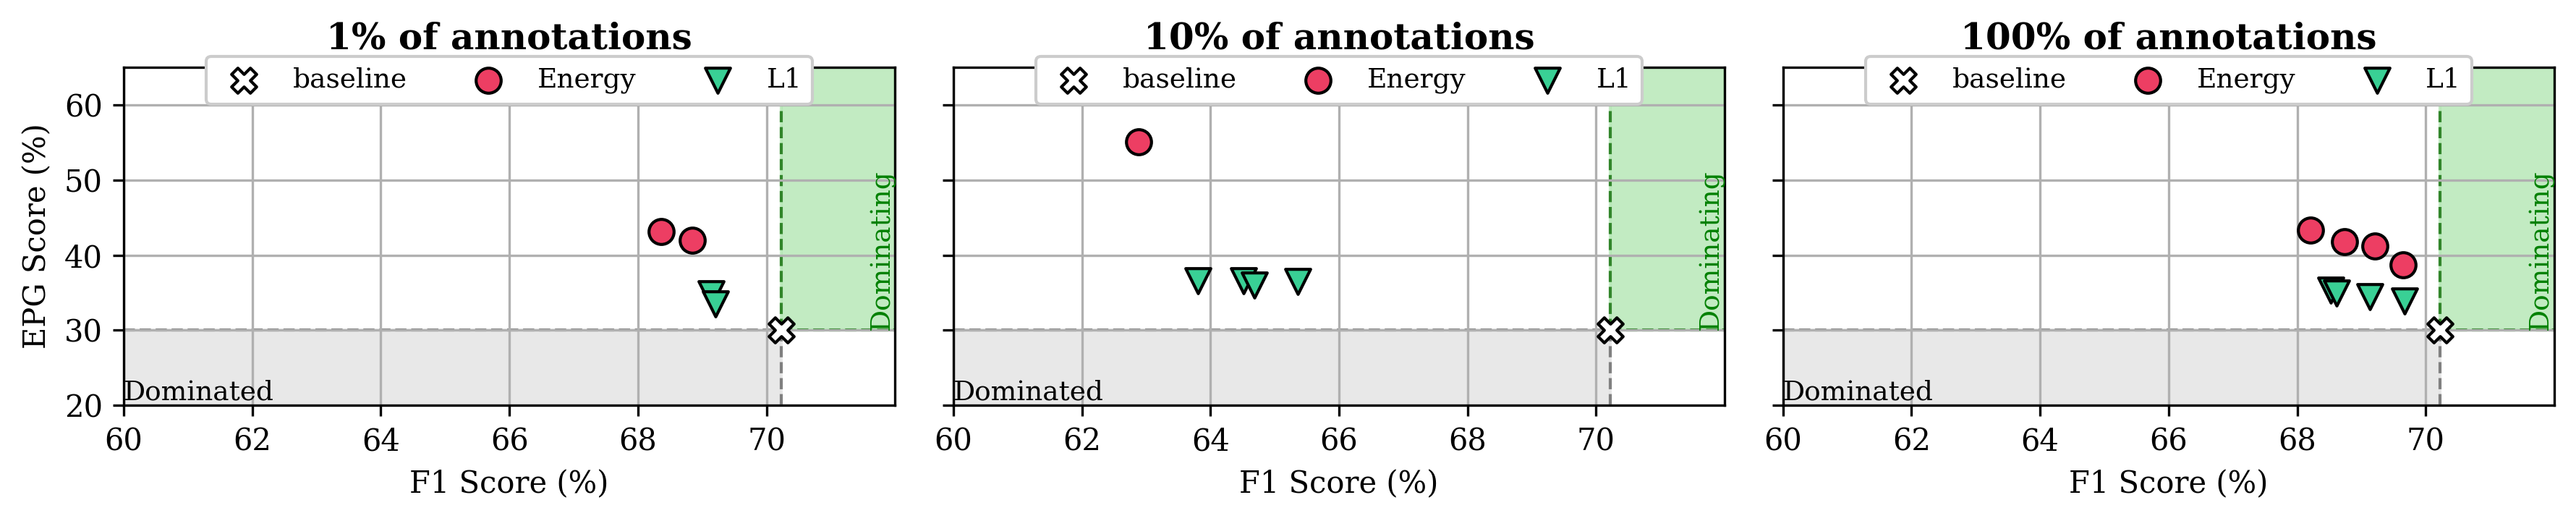

In [10]:
quant.plot_sparsity(sparse_data, baseline_data)

## Qualitative Results

For the checkpoint, please upload the checkpoint file provided via WeTransfer to the directory "checkpoints/"

In [11]:
checkpoint_to_test = 'checkpoints/COCO2014/bcos_finetunedobjlocpareto_attrBCos_loclossEnergy_origmodel_checkpoint_f1_best.pt_resnet50_lr0.0001_sll0.001_layerInput/pareto_front/model_checkpoint_pareto_0.6883_0.4277_0.0126_10.pt'

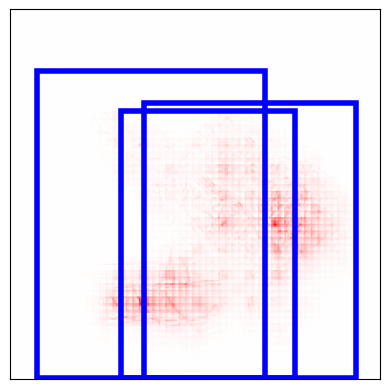

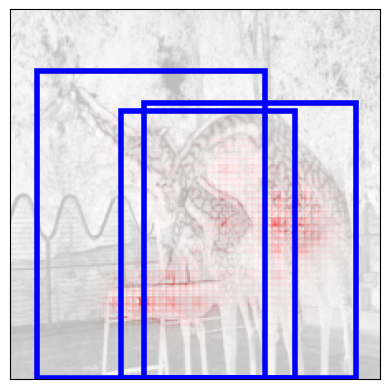

In [13]:
qual.contribution_map_plot(checkpoint_to_test)

Correlation Coefficient: 0.8208642855543093
P-value: 0.0


/home/scur1036/.conda/envs/fact/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/gpfs/home2/scur1036/FACT-AI/qual_plotting_utils.py:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_tick_labels, rotation=60, ha='center')


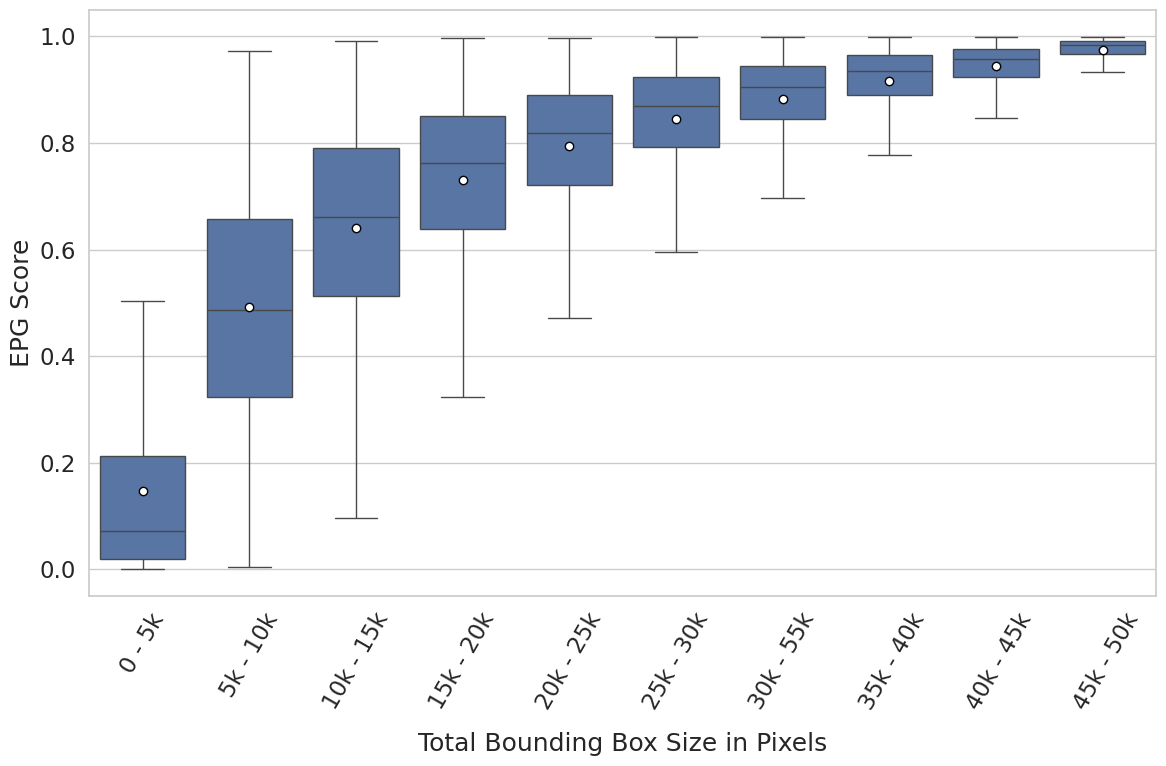

In [14]:
qual.plot_epg_vs_bbsize("epg_vs_bbsize.csv")

## Extensions - Survey

In [15]:
df = pd.read_csv("survey_results.csv")

### Q1

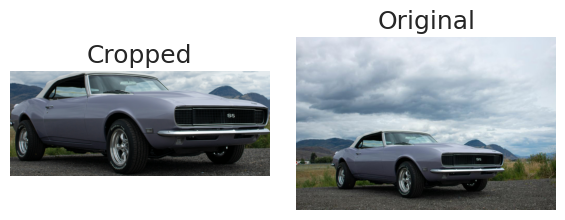

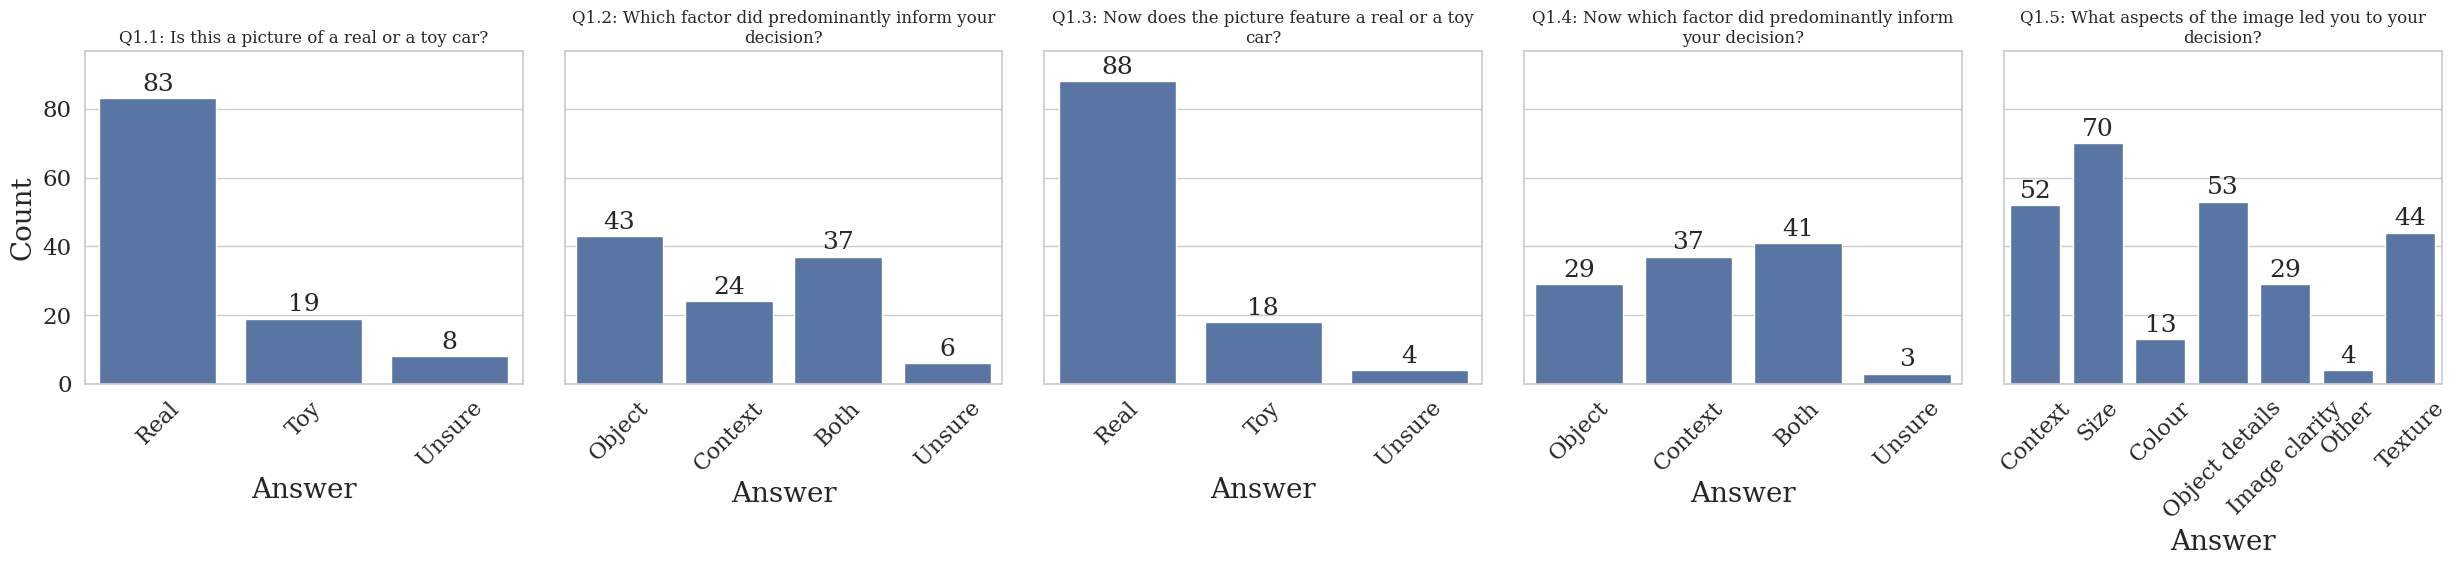

In [16]:
survey.display_images('Q1')
survey.plot_answer_distributions(survey.preprocess_df(df, 'Q1'))

### Q2

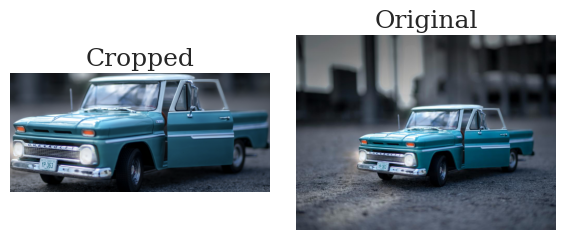

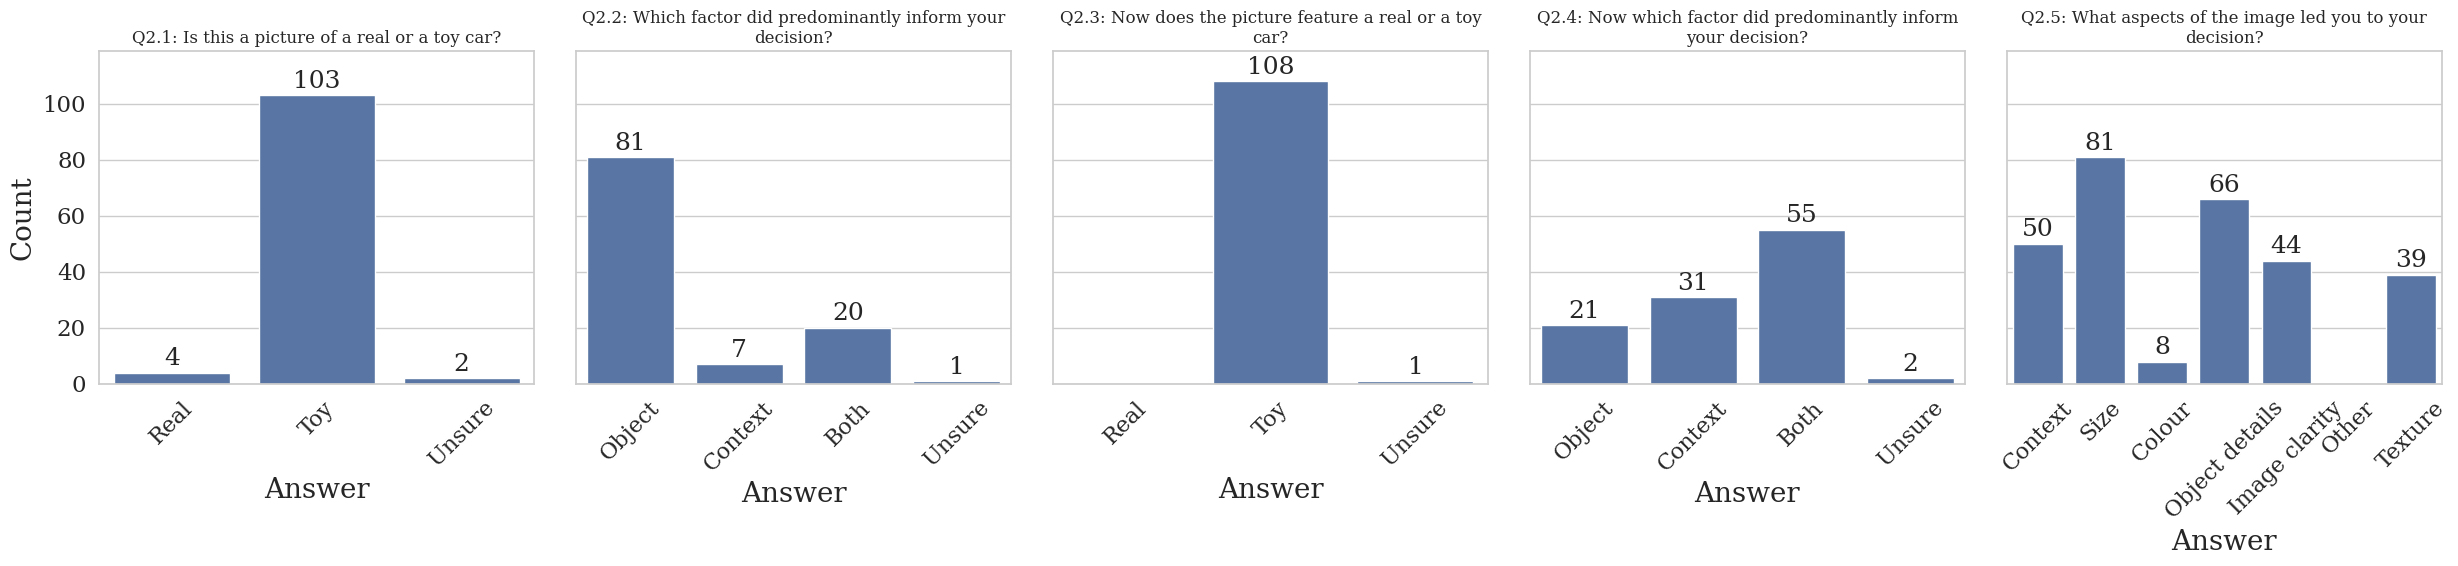

In [17]:
survey.display_images('Q2')
survey.plot_answer_distributions(survey.preprocess_df(df, 'Q2'))

### Q3

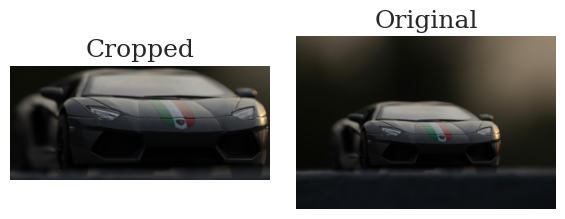

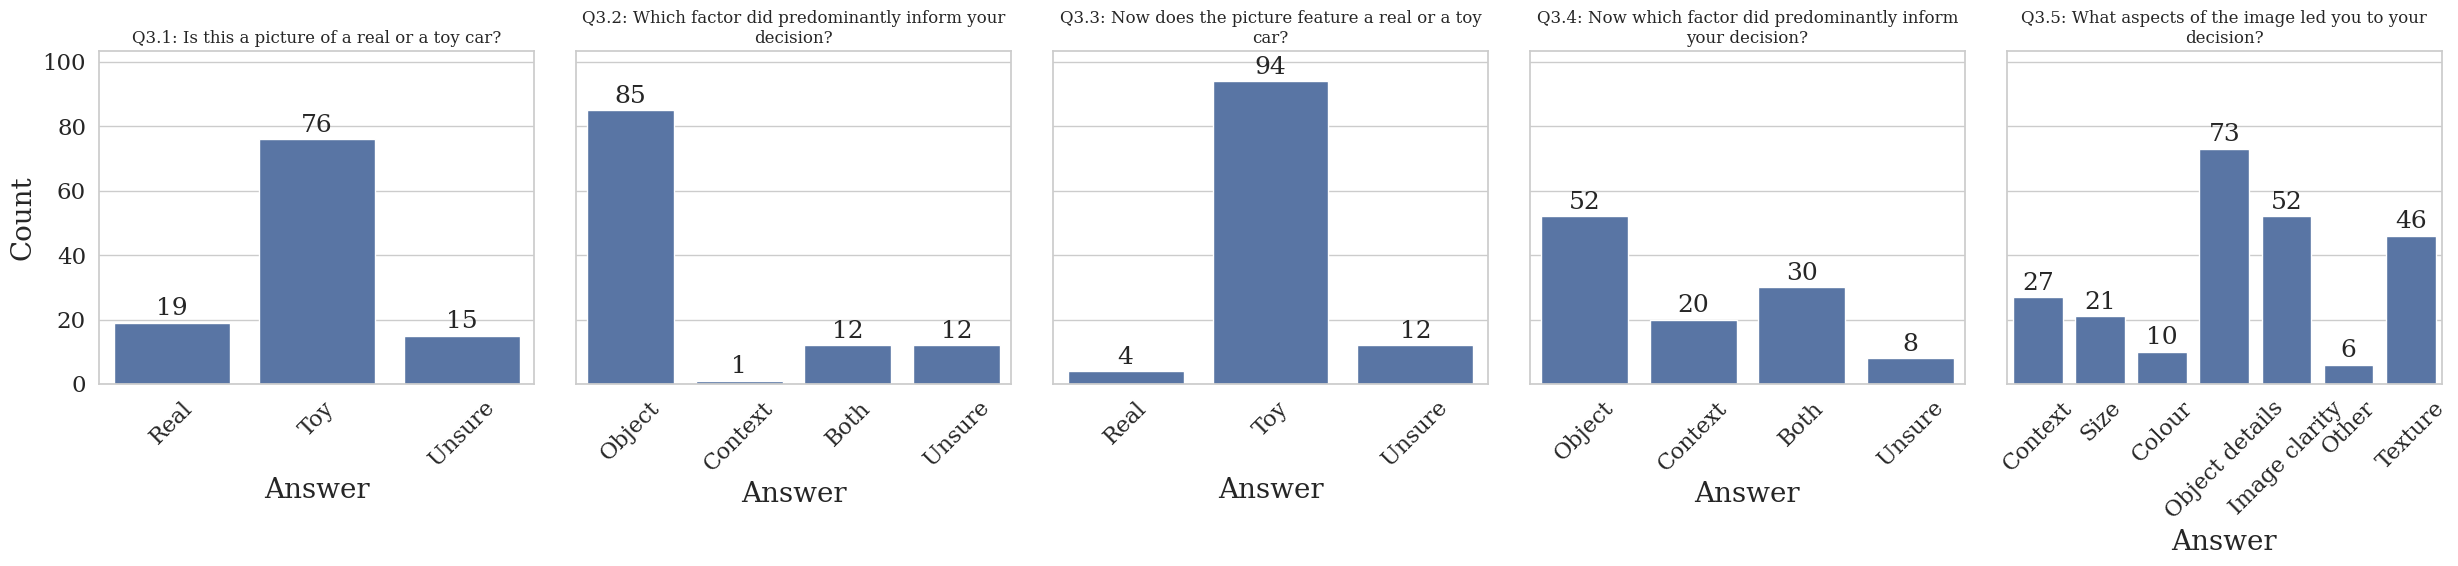

In [18]:
survey.display_images('Q3')
survey.plot_answer_distributions(survey.preprocess_df(df, 'Q3'))

### Q4

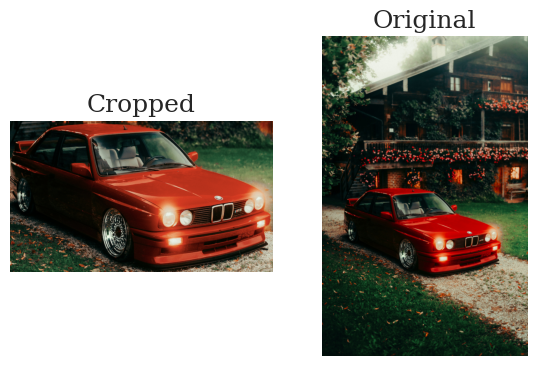

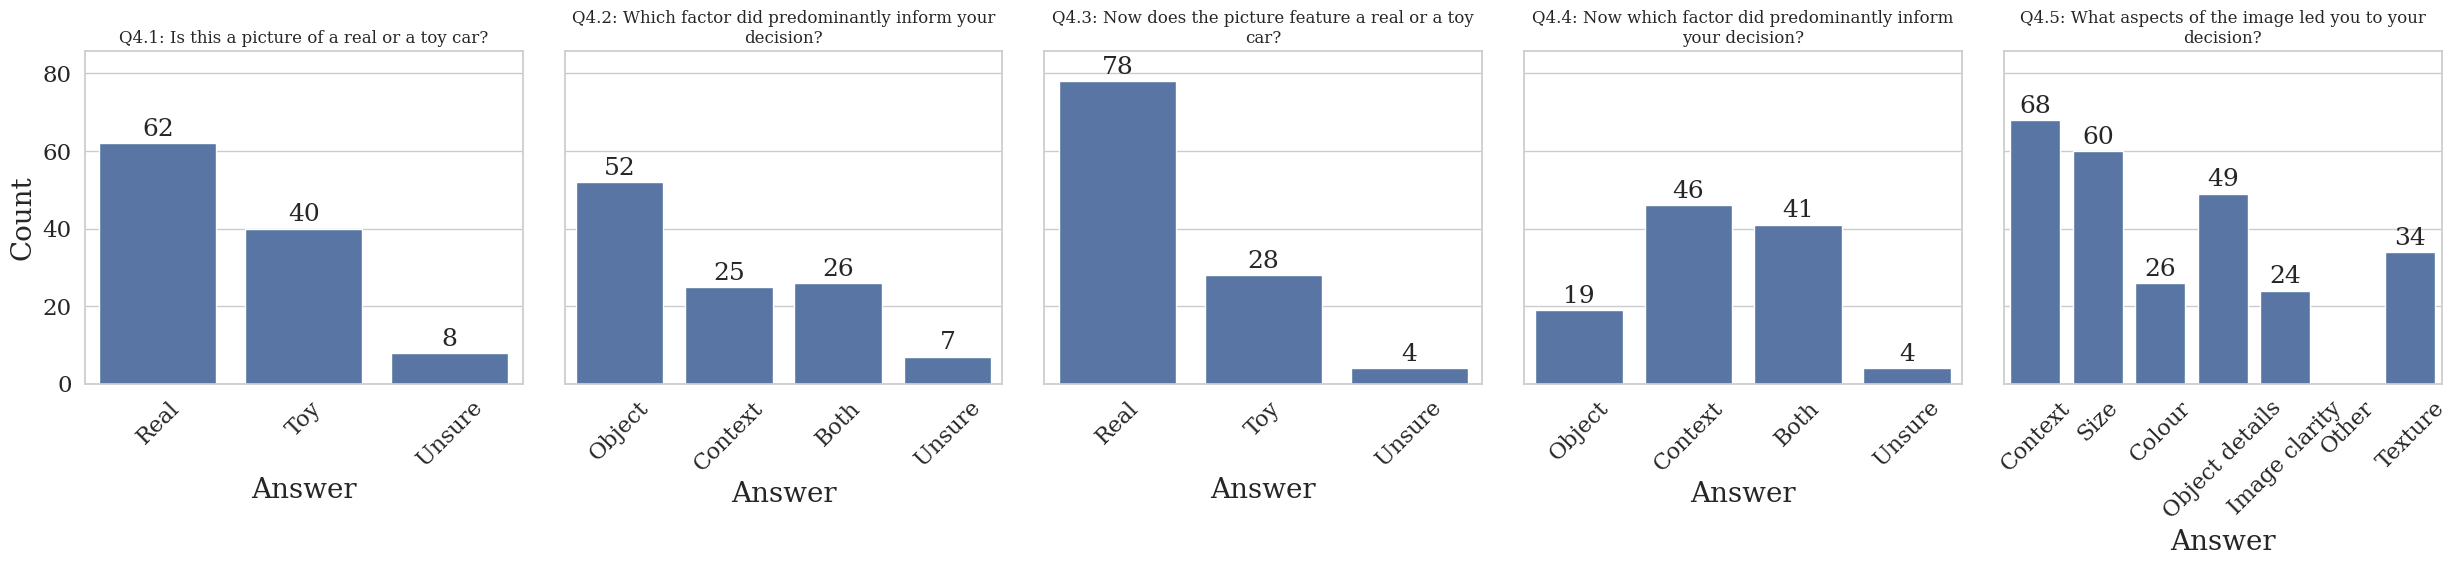

In [19]:
survey.display_images('Q4')
survey.plot_answer_distributions(survey.preprocess_df(df, 'Q4'))

### Q5

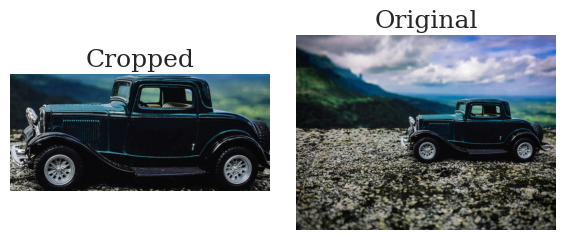

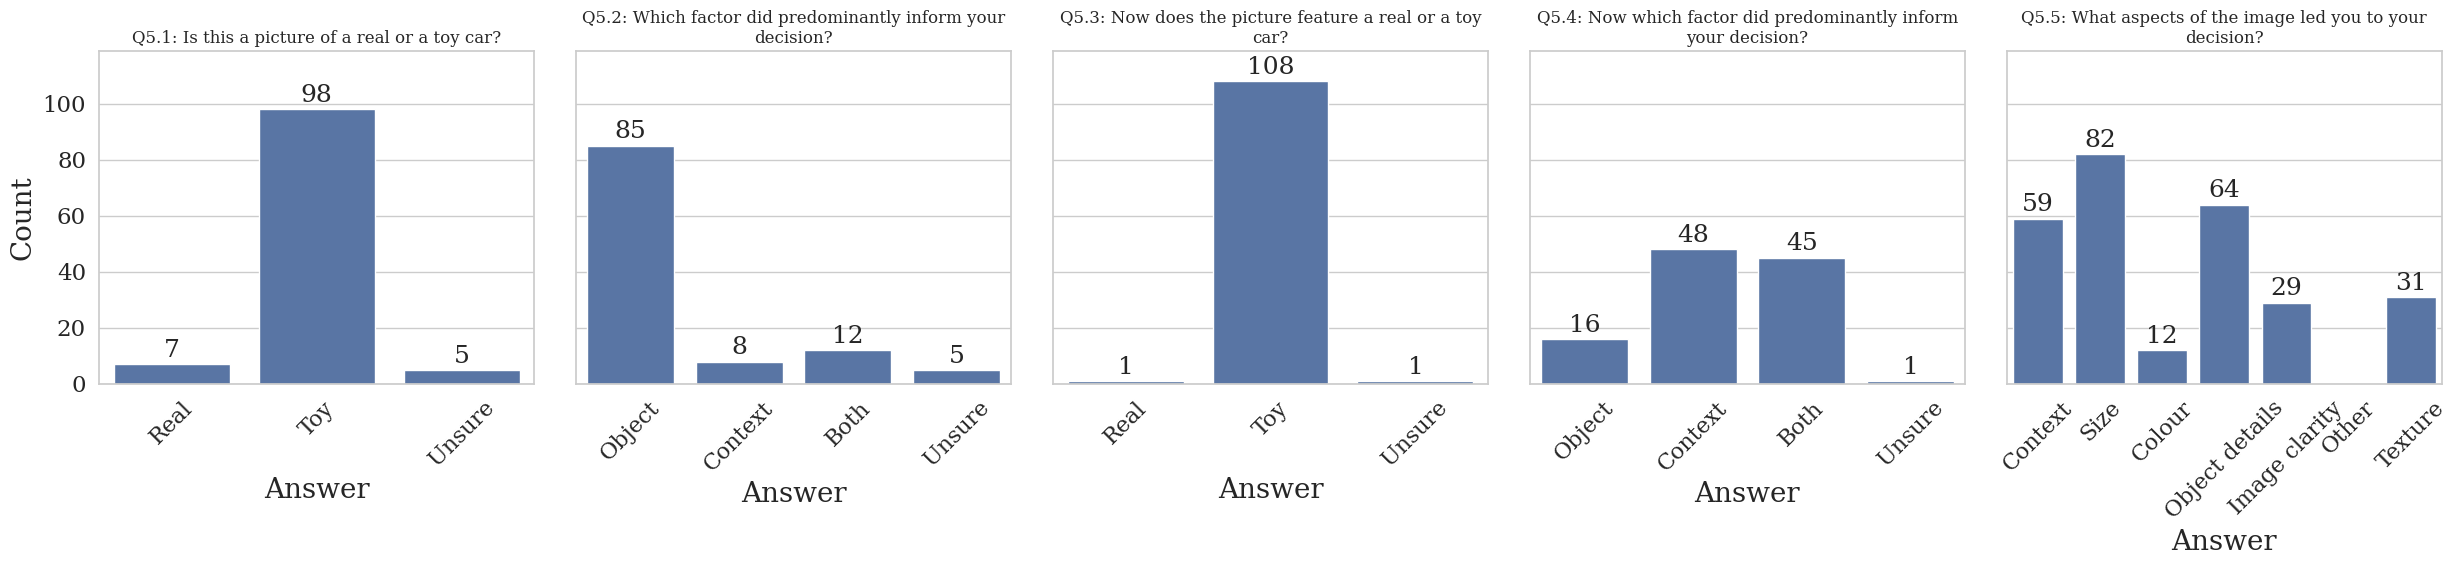

In [20]:
survey.display_images('Q5')
survey.plot_answer_distributions(survey.preprocess_df(df, 'Q5'))

### Q6

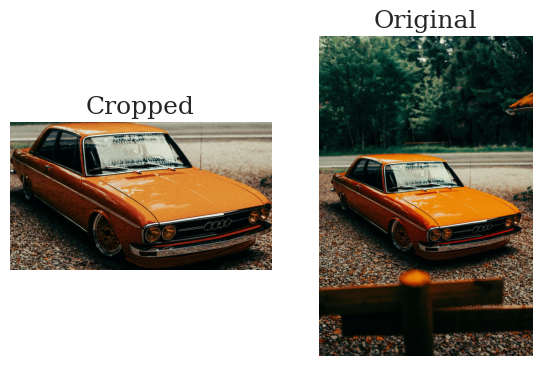

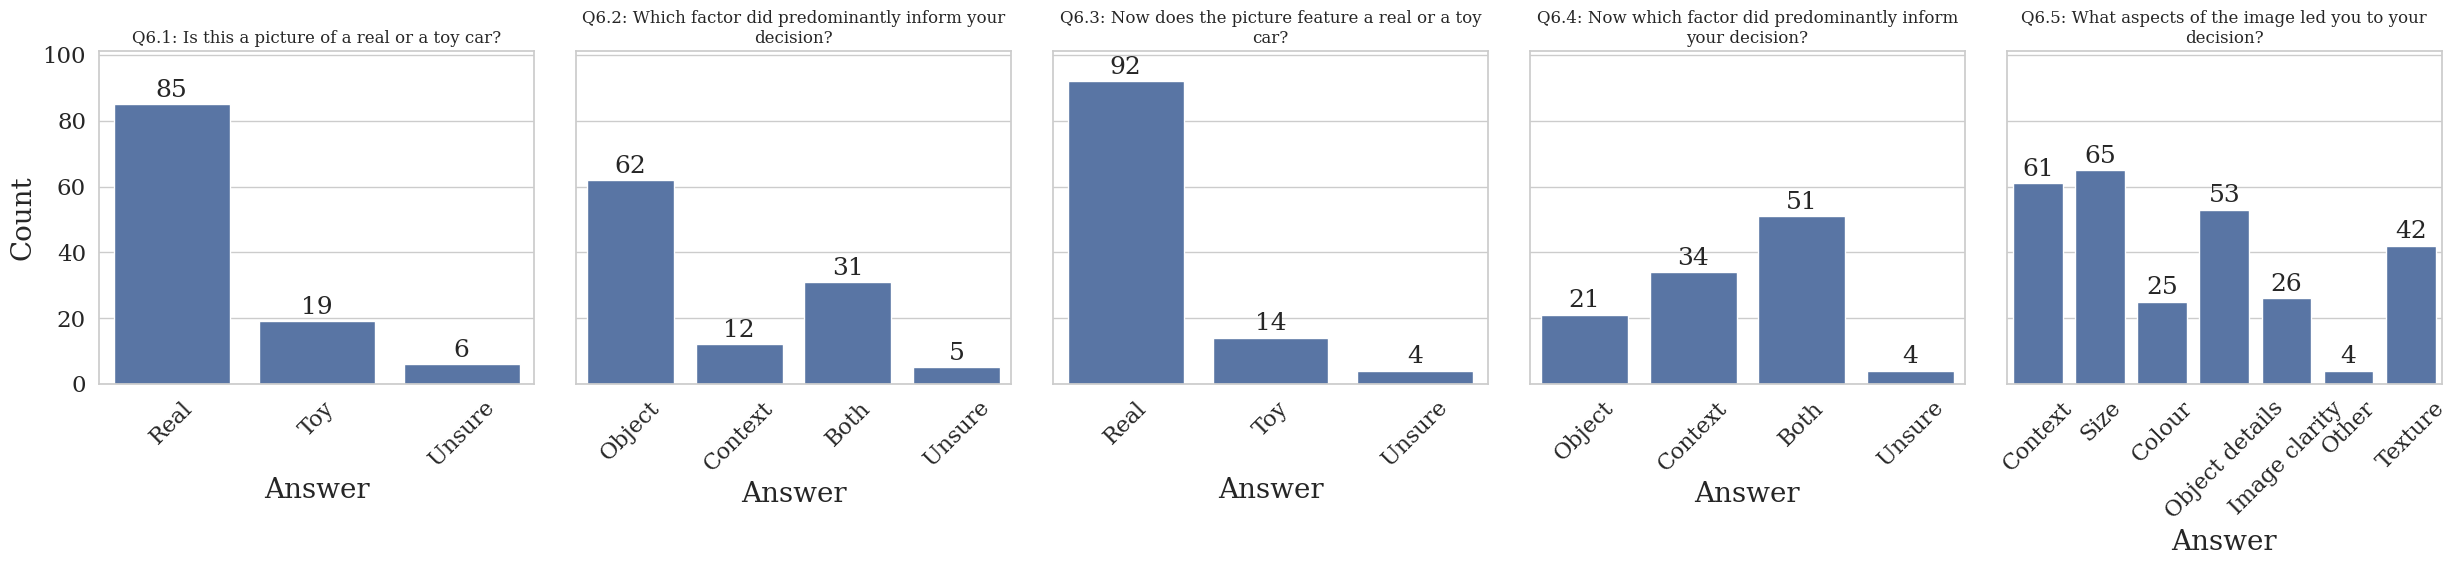

In [21]:
survey.display_images('Q6')
survey.plot_answer_distributions(survey.preprocess_df(df, 'Q6'))

### Further Analysis

#### Were the participants correct and how much did context help?

/home/scur1036/.conda/envs/fact/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/scur1036/.conda/envs/fact/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


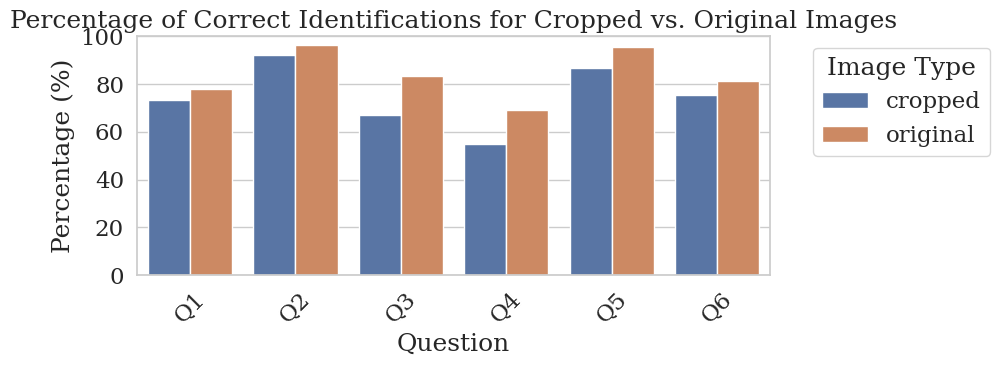

In [22]:
true_labels = {
    '1': 'Real',
    '2': 'Toy',
    '3': 'Toy',
    '4': 'Real',
    '5': 'Toy',
    '6': 'Real'
}

def get_accuracy(question_num, part, df, true_label):
    question = f'Q{question_num}{part}'
    if question in df.columns:
        responses = df[question].replace({'A real car': 'Real', 'A toy car': 'Toy', 'I am unsure': 'Misclassified', 'I am still unsure': 'Misclassified'})
        accuracy = (responses == true_label).mean() * 100
        return accuracy
    return None


plot_data = []
for q_num, label in true_labels.items():
    for part in ['.1', '.3']:
        accuracy = get_accuracy(q_num, part, df, label)
        if accuracy is not None:  # Ensure the question exists in the DataFrame
            plot_data.append({'Question': f'Q{q_num}', 'Part': part, 'Accuracy': accuracy})

accuracy_df = pd.DataFrame(plot_data)
accuracy_df['Part'] = accuracy_df['Part'].map({'.1': 'cropped', '.3': 'original'})

plt.figure(figsize=(10, 4))
sns.barplot(x='Question', y='Accuracy', hue='Part', data=accuracy_df, dodge=True)
plt.title('Percentage of Correct Identifications for Cropped vs. Original Images')
plt.xlabel('Question')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)

plt.legend(title='Image Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
# plt.savefig('Cropped_vs_Original_percentage.png')
plt.show()

##### Paired t-test

In [23]:
pivot_df = accuracy_df.pivot(index='Question', columns='Part', values='Accuracy')
pivot_df = pivot_df.dropna()

t_stat, p_value = stats.ttest_rel(pivot_df['cropped'], pivot_df['original'])

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

alpha = 0.05
if p_value < alpha:
    print("There is a significant difference in accuracy between cropped and original images.")
else:
    print("There is no significant difference in accuracy between cropped and original images.")


T-statistic: -4.418434149761855
P-value: 0.006902047707241708
There is a significant difference in accuracy between cropped and original images.


#### How many times did participants change their mind after seeing the original image?

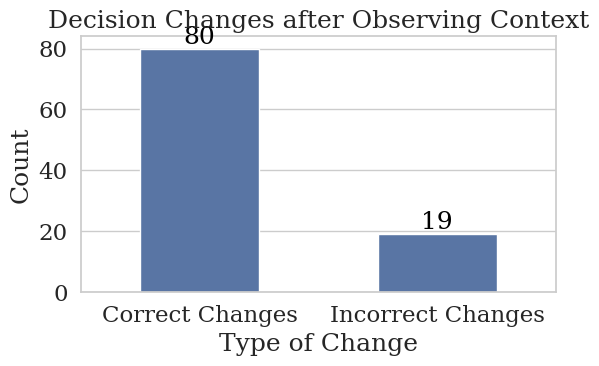

In [24]:
true_labels = {
    'Q1.1': 'Real', 'Q2.1': 'Toy', 'Q3.1': 'Toy', 'Q4.1': 'Real', 'Q5.1': 'Toy', 'Q6.1': 'Real',
    'Q1.3': 'Real', 'Q2.3': 'Toy', 'Q3.3': 'Toy', 'Q4.3': 'Real', 'Q5.3': 'Toy', 'Q6.3': 'Real'
}

correct_changes = 0
incorrect_changes = 0

def map_response(response):
    if response == 'A real car':
        return 'Real'
    elif response == 'A toy car':
        return 'Toy'
    return None

for index, row in df.iterrows():
    for q_num in range(1, 7):
        q1 = f'Q{q_num}.1'
        q3 = f'Q{q_num}.3'
        
        response_1 = map_response(row[q1])
        response_3 = map_response(row[q3])
        
        true_label_1 = true_labels[q1]
        true_label_3 = true_labels[q3]
        
        if response_1 != true_label_1 and response_3 == true_label_3:
            correct_changes += 1  # Was wrong in .1 but corrected in .3
        elif response_1 == true_label_1 and response_3 != true_label_3:
            incorrect_changes += 1  # Was right in .1 but changed to a wrong answer in .3

data = {
    'Change Type': ['Correct Changes', 'Incorrect Changes'],
    'Counts': [correct_changes, incorrect_changes]
}
df_changes = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
sns.barplot(x='Change Type', y='Counts', data=df_changes, width=0.5)
plt.title('Decision Changes after Observing Context')

# Annotating counts above bars
for index, row in df_changes.iterrows():
    plt.text(index, row['Counts'], str(row['Counts']), color='black', ha="center", va='bottom')

plt.xlabel('Type of Change')
plt.ylabel('Count')
plt.tight_layout()
# plt.savefig('Decision_changes.png')
plt.show()

##### Chi-squared independence test

In [25]:
correct_changes = 80
total_changes = 99

# The null hypothesis is that the probability of a correct change is 0.5
# (no better than random chance)
result = binomtest(correct_changes, total_changes, p=0.5, alternative='greater')

p_value = result.pvalue
print(f'P-value: {p_value}')

alpha = 0.05
if p_value < alpha:
    print("There is a significant difference, suggesting context improves decision accuracy.")
else:
    print("There is no significant difference, suggesting context does not improve decision accuracy.")


P-value: 2.1970139145447113e-10
There is a significant difference, suggesting context improves decision accuracy.


##### McNemar's test

In [26]:
correct_changes = 0
incorrect_changes = 0
no_change_incorrect = 0
no_change_correct = 0

for index, row in df.iterrows():
    for q_num in range(1, 7):
        q1 = f'Q{q_num}.1'
        q3 = f'Q{q_num}.3'
        
        response_1 = map_response(row[q1])
        response_3 = map_response(row[q3])
        
        true_label_1 = true_labels[q1]
        true_label_3 = true_labels[q3]
        
        if response_1 != true_label_1 and response_3 == true_label_3:
            correct_changes += 1  # Was wrong in .1 but corrected in .3
        elif response_1 == true_label_1 and response_3 != true_label_3:
            incorrect_changes += 1  # Was right in .1 but changed to a wrong answer in .3
        elif response_1 != true_label_1 and response_3 != true_label_3:
            no_change_incorrect += 1  # Was wrong in .1 and stayed wrong in .3
        elif response_1 == true_label_1 and response_3 == true_label_3:
            no_change_correct += 1  # Was right in .1 and stayed right in .3

# The contingency table for McNemar's test:
#
#                   after_correct
# before_correct      no     yes
#             no       a       b
#            yes       c       d

table = [[no_change_incorrect, correct_changes],
         [incorrect_changes, no_change_correct]]

result = mcnemar(table, exact=True)

print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))

alpha = 0.05
if result.pvalue < alpha:
    print('There is a significant change in the decisions after observing context.')
else:
    print('There is no significant change in the decisions after observing context.')

statistic=19.000, p-value=0.000
There is a significant change in the decisions after observing context.


#### Predominant decision influence when seeing full images

In [27]:
context_count = 0
object_count = 0

for q_num in range(1, 7):
    q_4 = f'Q{q_num}.4'
    
    if q_4 in df.columns:
        context_count += np.sum(df[q_4] == 'Surrounding (Environment around the car)')
        object_count += np.sum(df[q_4] == 'Object')

print(f"Context: {context_count}")
print(f"Object: {object_count}")

Context: 216
Object: 158


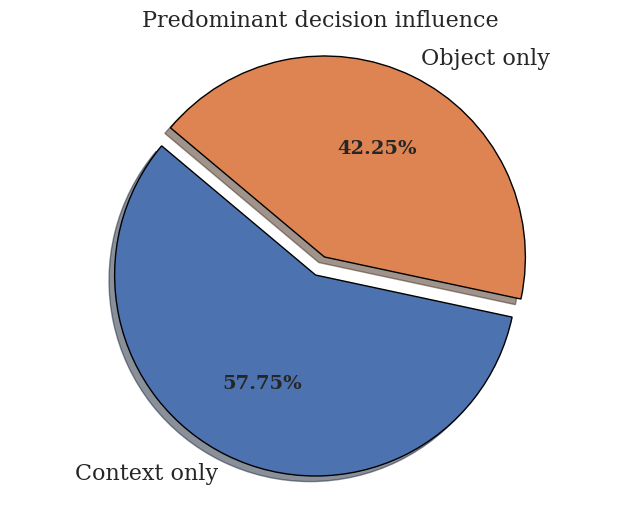

In [28]:
labels = ['Context only', 'Object only']
sizes = [context_count, object_count]
colors = sns.color_palette()[0:2]
explode = (0.1, 0)

# Custom autopct function to control font size
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%'.format(p=pct,v=val)
    return my_format

plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct=autopct_format(sizes),
                                   startangle=140, shadow=True, wedgeprops={'edgecolor': 'black'})

plt.setp(texts, size=16)
plt.setp(autotexts, size=14, weight="bold")

plt.title('Predominant decision influence', fontsize=16)
plt.axis('equal')

# plt.savefig('Object_context_pie.png')

plt.show()

In [29]:
object_count = 0
context_both_count = 0

for q_num in range(1, 7):
    q_4 = f'Q{q_num}.4'
    
    if q_4 in df.columns:
        object_count += np.sum(df[q_4] == 'Object')
        context_both_count += np.sum(df[q_4] == 'Surrounding (Environment around the car)')
        context_both_count += np.sum(df[q_4] == 'Both equally')

print(f"Context + Both: {context_both_count}")
print(f"Object: {object_count}")

Context + Both: 479
Object: 158


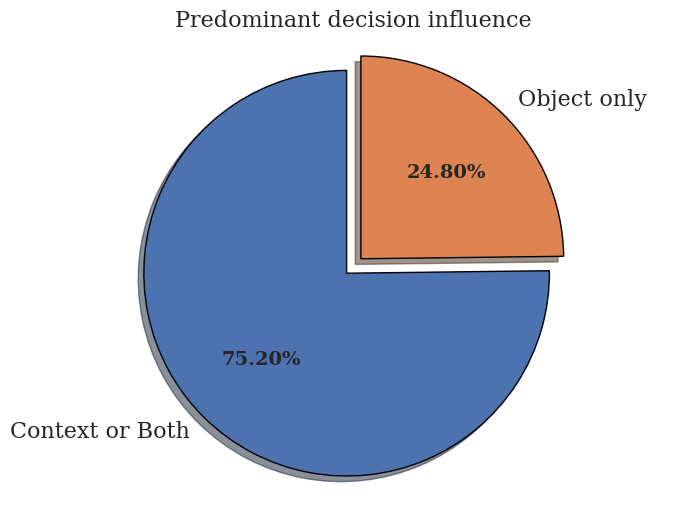

In [30]:
labels = ['Context or Both', 'Object only']
sizes = [context_both_count, object_count]
colors = sns.color_palette()[0:2]
explode = (0.1, 0)

# Custom autopct function to control font size
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%'.format(p=pct,v=val)
    return my_format

plt.figure(figsize=(8, 6))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct=autopct_format(sizes),
                                   startangle=90, shadow=True, wedgeprops={'edgecolor': 'black'})

plt.setp(texts, size=16)
plt.setp(autotexts, size=14, weight="bold")

plt.title('Predominant decision influence', fontsize=16)
plt.axis('equal')

# plt.savefig('Object_both_pie.png')

plt.show()

#### Incorrect answers: What did people focus on?

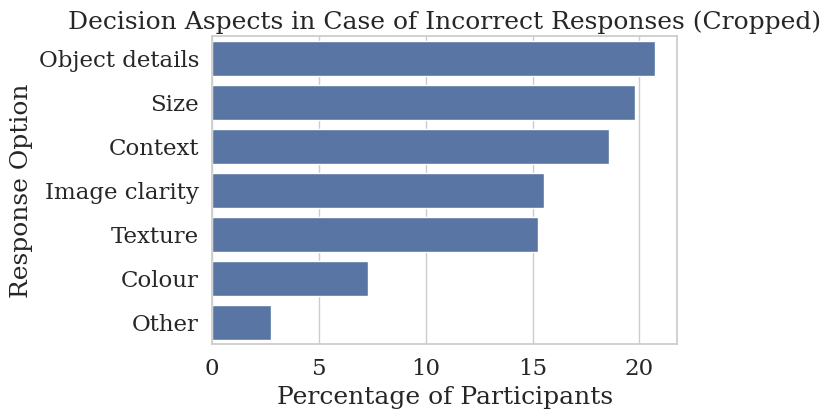

In [31]:
# First two rows are not survey answers
df_responses = df.iloc[2:]

true_labels = {
    '1': 'Real',
    '2': 'Toy',
    '3': 'Toy',
    '4': 'Real',
    '5': 'Toy',
    '6': 'Real'
}

label_mapping = {
    'Context/environment in which the (toy) car can be seen': 'Context',
    'Size in relation to other objects': 'Size',
    'Colour': 'Colour',
    'Details on the (toy) car': 'Object details',
    'Blurriness or sharpness of fore/background': 'Image clarity',
    'Other': 'Other',
    'Texture/reflections or graininess': 'Texture'
}

def map_response(response):
    if response == 'A real car':
        return 'Real'
    elif response == 'A toy car':
        return 'Toy'
    return 'Other'

all_responses = []
for q_num, correct_label in true_labels.items():
    q_1 = f'Q{q_num}.1'
    q_5 = f'Q{q_num}.5'
    
    if q_1 in df_responses.columns and q_5 in df_responses.columns:
        for index, row in df_responses.iterrows():
            response_1 = map_response(row[q_1])
            if response_1 != correct_label:
                responses_5 = row[q_5] if pd.notnull(row[q_5]) else ""
                mapped_responses_5 = [label_mapping.get(resp, resp) for resp in responses_5.split(',') if resp]
                all_responses.extend(mapped_responses_5)

response_counts = pd.Series(all_responses).value_counts(normalize=True).reset_index()
response_counts.columns = ['Response', 'Percentage']
response_counts['Percentage'] *= 100

plt.figure(figsize=(6, 4))
sns.barplot(x='Percentage', y='Response', data=response_counts)
plt.title('Decision Aspects in Case of Incorrect Responses (Cropped)')
plt.xlabel('Percentage of Participants')
plt.ylabel('Response Option')

# plt.savefig('Decision_aspects_cropped.png')

plt.show()

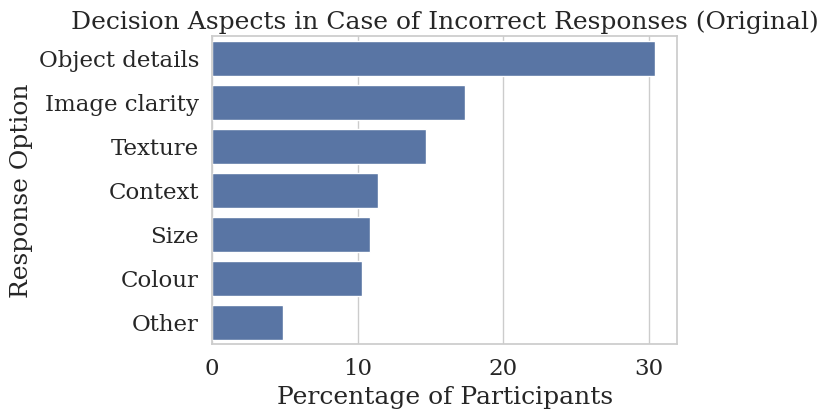

In [32]:
all_responses = []

for q_num, correct_label in true_labels.items():
    q_1 = f'Q{q_num}.3'
    q_5 = f'Q{q_num}.5'
    
    if q_1 in df_responses.columns and q_5 in df_responses.columns:
        for index, row in df_responses.iterrows():
            response_1 = map_response(row[q_1])
            if response_1 != correct_label:
                responses_5 = row[q_5] if pd.notnull(row[q_5]) else ""
                mapped_responses_5 = [label_mapping.get(resp, resp) for resp in responses_5.split(',') if resp]
                all_responses.extend(mapped_responses_5)

response_counts = pd.Series(all_responses).value_counts(normalize=True).reset_index()
response_counts.columns = ['Response', 'Percentage']
response_counts['Percentage'] *= 100

plt.figure(figsize=(6, 4))
sns.barplot(x='Percentage', y='Response', data=response_counts)
plt.title('Decision Aspects in Case of Incorrect Responses (Original)')
plt.xlabel('Percentage of Participants')
plt.ylabel('Response Option')

# plt.savefig('Decision_aspects_full.png')

plt.show()

## Extensions - EPG* Loss

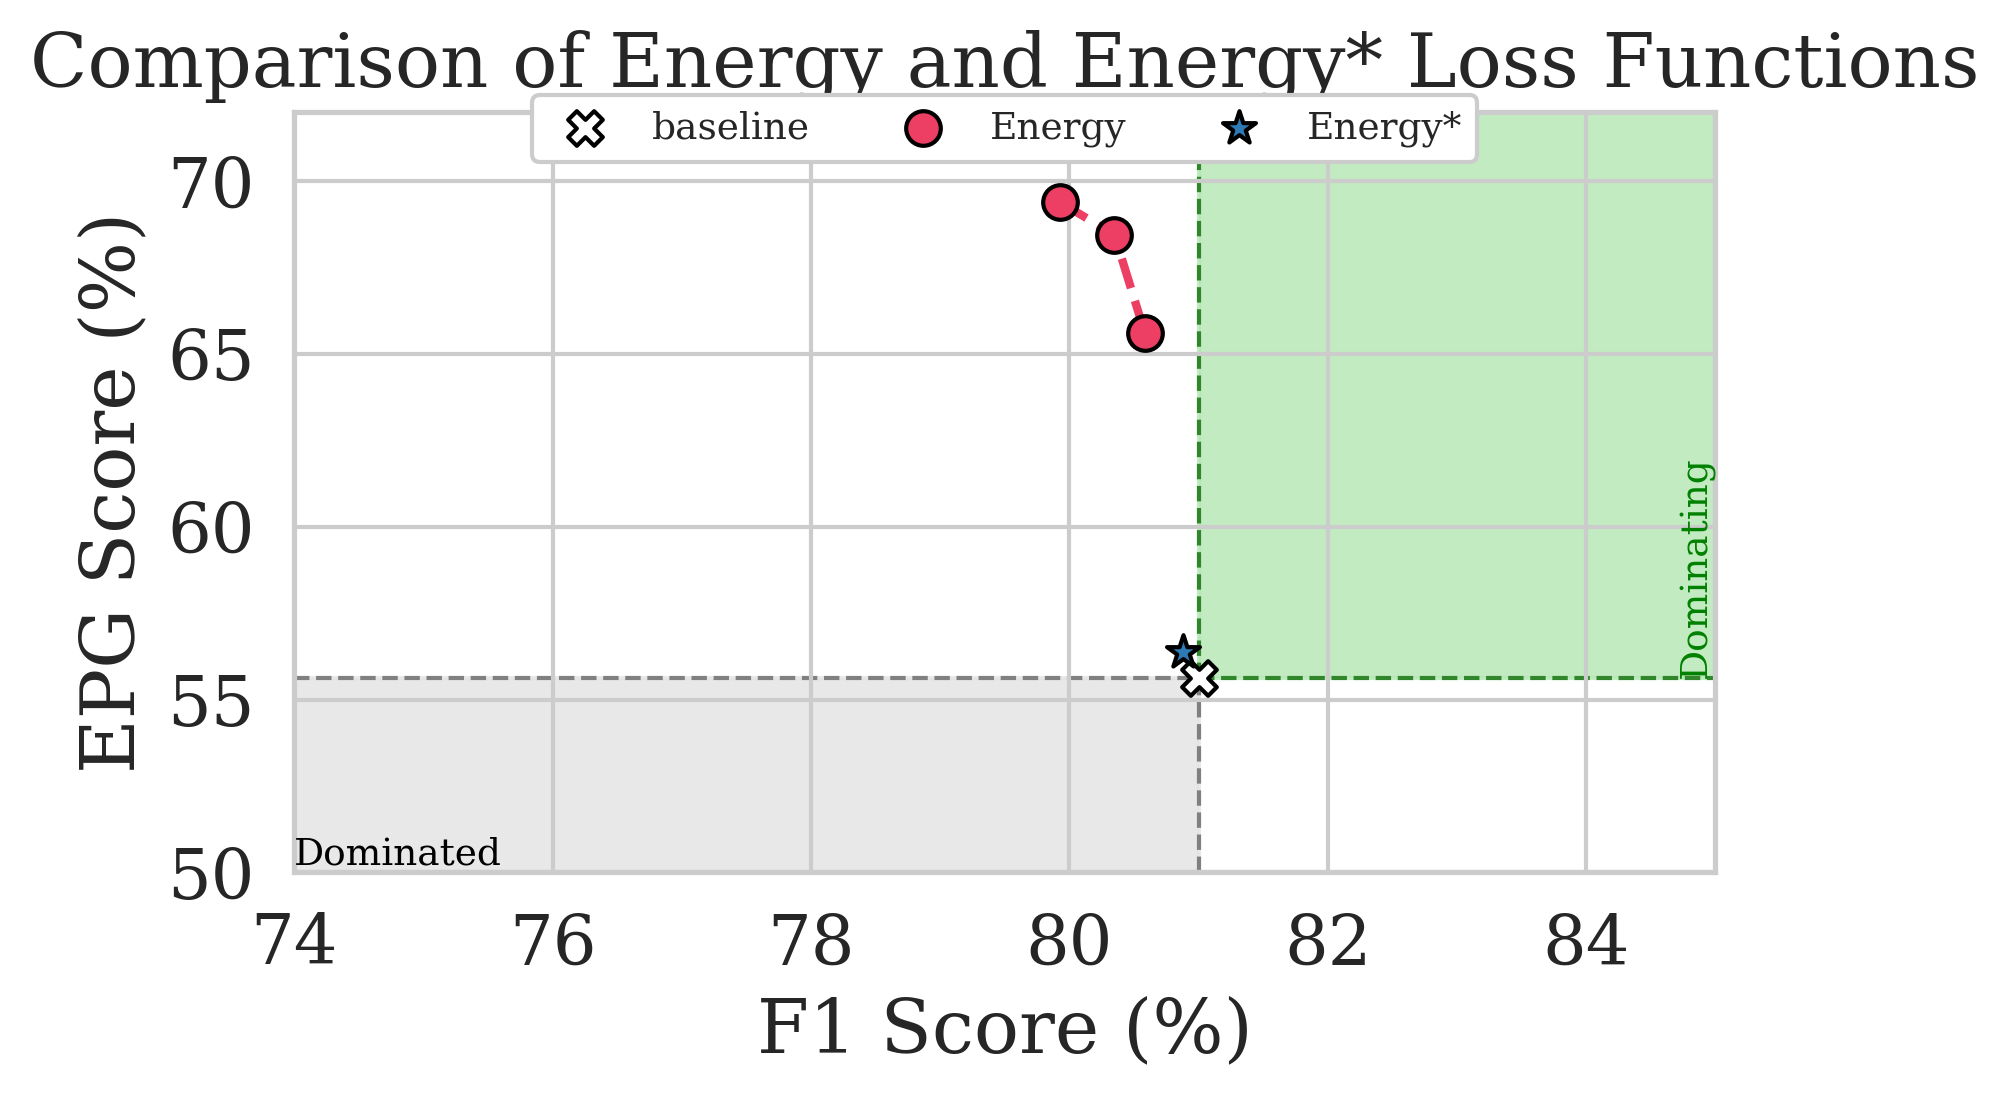

In [33]:
epg_star_baseline_data, epg_star_data = quant.load_epg_star_json("result_jsons_epg*/")
quant.plot_epg_star(epg_star_data, epg_star_baseline_data, "Energy", "Energy*")

## Extensions - Segmentation Masks & Sparse Annotations

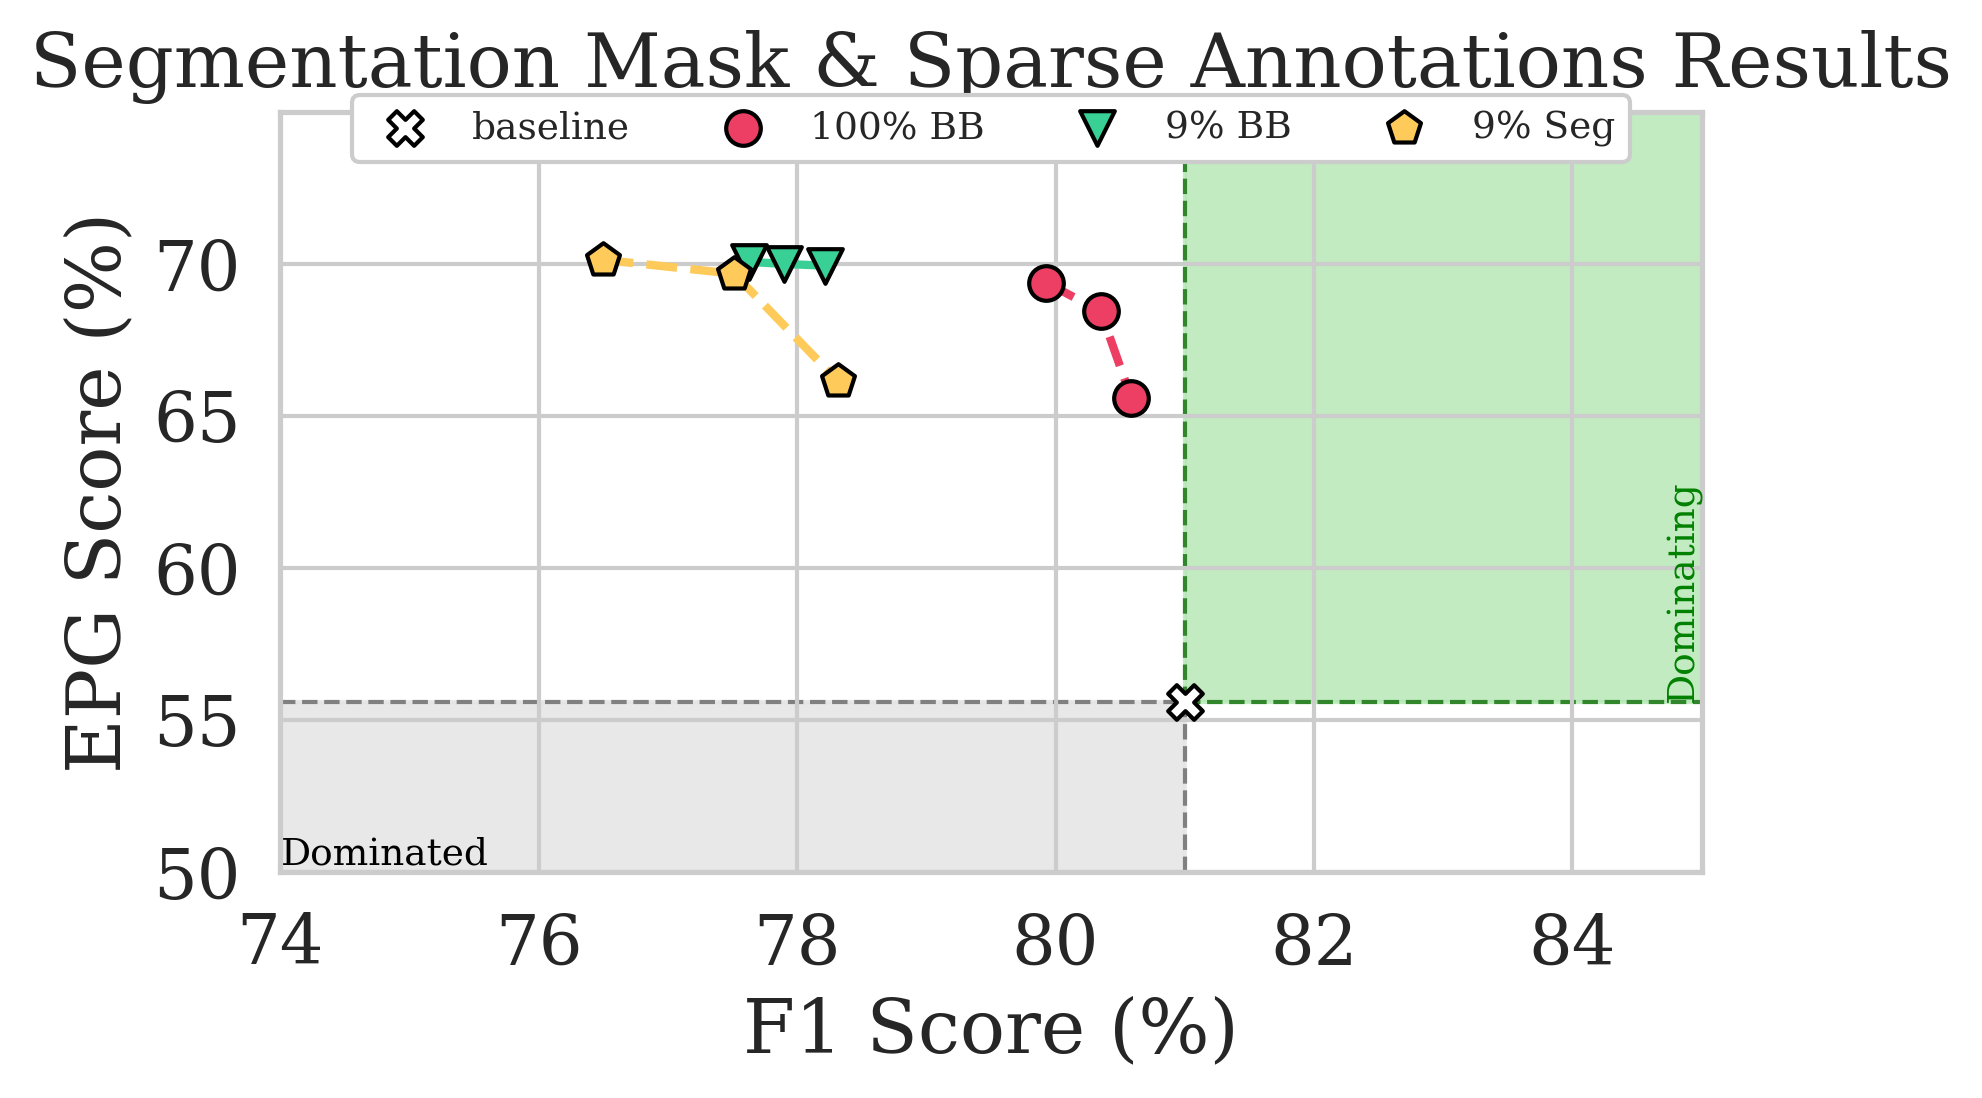

In [34]:
seg_mask_baseline_data, seg_mask_data = quant.load_seg_mask_json("result_jsons_seg_mask/")
quant.plot_seg_mask(seg_mask_data, seg_mask_baseline_data)